# Rain in Australia - Post EDA
[https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package/data?select=weatherAUS.csv](https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package/data?select=weatherAUS.csv)

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC,LinearSVC

In [31]:
weatherAUS = pd.read_csv('weatherAUS.csv')

In [32]:
def combine_values(df, column1, column2, verbose=False):
    result = pd.Series(index=df.index)

    for i, row in df.iterrows():
        if pd.isna(row[column1]) and pd.isna(row[column2]):
            result[i] = np.nan
        elif pd.isna(row[column1]):
            result[i] = row[column2]
        elif pd.isna(row[column2]):
            result[i] = row[column1]
        else:
            result[i] = (row[column1] + row[column2]) / 2
    if verbose:
        # Afficher le nombre de NaN dans les colonnes d'entrée et la colonne de sortie
        num_nan_input1 = df[column1].isna().sum()
        num_nan_input2 = df[column2].isna().sum()
        num_nan_output = result.isna().sum()
        print(f"NaN dans {column1}: {num_nan_input1}")
        print(f"NaN dans {column2}: {num_nan_input2}")
        print(f"NaN dans la colonne de sortie: {num_nan_output}")

    return result

In [33]:
def display_nan_proportion(dataframe: pd.DataFrame, dataframe_name: str = "le dataframe"):
    nan_proportions = (dataframe.isna().sum() / len(dataframe)) * 100
    nan_proportions = nan_proportions.sort_values(ascending=False)
    
    plt.figure(figsize=(8, 5))
    sns.barplot(x=nan_proportions.values, y=nan_proportions.index, hue=nan_proportions.index, palette='viridis', legend=False)
    plt.xlabel('Proportion de NaN (%)')
    plt.title(f'Proportions de NaN par colonne dans {dataframe_name}')
    plt.gca().invert_yaxis()  # La colonne avec le plus de NaN en bas
    plt.show()

In [34]:
weatherAUS['Temp'] = combine_values(weatherAUS, column1='Temp9am', column2='Temp3pm', verbose=True)
weatherAUS['Humidity'] = combine_values(weatherAUS, column1='Humidity9am', column2='Humidity3pm', verbose=True)
weatherAUS['WindSpeed'] = combine_values(weatherAUS, column1='WindSpeed9am', column2='WindSpeed3pm', verbose=True)
weatherAUS['Pressure'] = combine_values(weatherAUS, column1='Pressure9am', column2='Pressure3pm', verbose=True)

NaN dans Temp9am: 1767
NaN dans Temp3pm: 3609
NaN dans la colonne de sortie: 1129
NaN dans Humidity9am: 2654
NaN dans Humidity3pm: 4507
NaN dans la colonne de sortie: 1887
NaN dans WindSpeed9am: 1767
NaN dans WindSpeed3pm: 3062
NaN dans la colonne de sortie: 1213
NaN dans Pressure9am: 15065
NaN dans Pressure3pm: 15028
NaN dans la colonne de sortie: 14804


In [35]:
weatherAUS['Date'] = pd.to_datetime(weatherAUS['Date'])
weatherAUS['Month'] = weatherAUS['Date'].dt.month
weatherAUS['Year'] = weatherAUS['Date'].dt.year

In [36]:
columns_to_keep = ['MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed', 'Humidity', 'WindSpeed', 'Pressure', 'Month', 'Temp', 'RainToday', 'Year', 'RainTomorrow']

weatherAUS = weatherAUS[columns_to_keep]

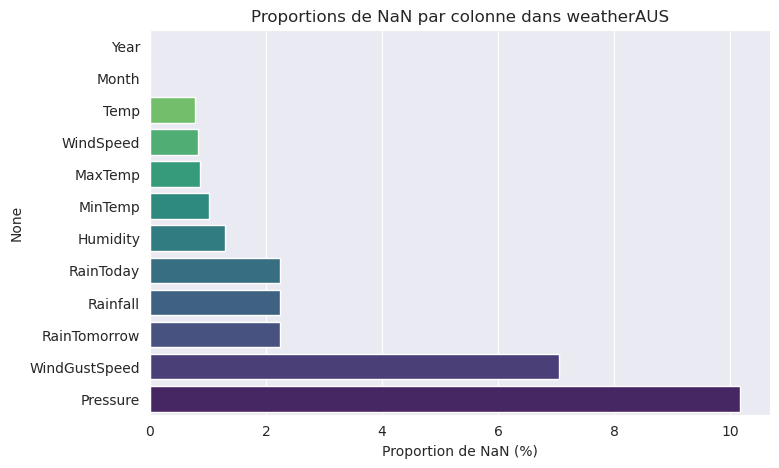

In [37]:
display_nan_proportion(dataframe=weatherAUS, dataframe_name="weatherAUS")

In [38]:
weatherAUS.dropna(inplace=True)

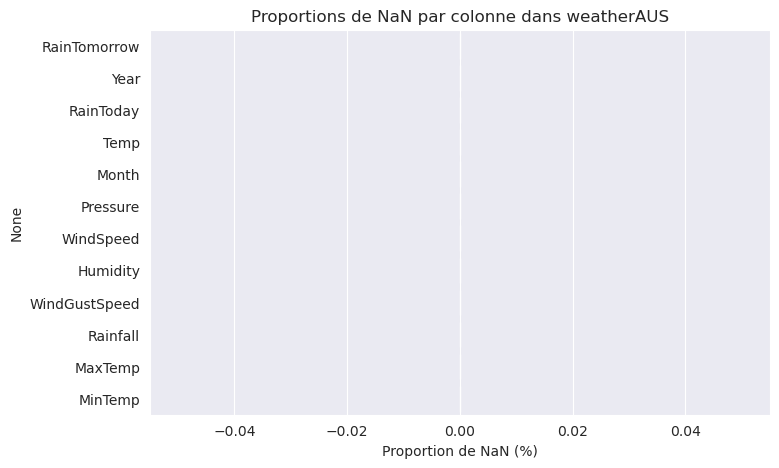

In [39]:
display_nan_proportion(dataframe=weatherAUS, dataframe_name="weatherAUS")

In [40]:
len(weatherAUS)

120960

In [41]:
weatherAUS['RainTomorrow'] = weatherAUS['RainTomorrow'].map({'Yes': True, 'No': False})
weatherAUS['RainToday'] = weatherAUS['RainToday'].map({'Yes': True, 'No': False})

In [42]:
weatherAUS

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,Humidity,WindSpeed,Pressure,Month,Temp,RainToday,Year,RainTomorrow
0,13.4,22.9,0.6,44.0,46.5,22.0,1007.40,12,19.35,False,2008,False
1,7.4,25.1,0.0,44.0,34.5,13.0,1009.20,12,20.75,False,2008,False
2,12.9,25.7,0.0,46.0,34.0,22.5,1008.15,12,22.10,False,2008,False
3,9.2,28.0,0.0,24.0,30.5,10.0,1015.20,12,22.30,False,2008,False
4,17.5,32.3,1.0,41.0,57.5,13.5,1008.40,12,23.75,False,2008,False
...,...,...,...,...,...,...,...,...,...,...,...,...
145454,3.5,21.8,0.0,31.0,43.0,14.0,1022.95,6,15.15,False,2017,False
145455,2.8,23.4,0.0,31.0,37.5,12.0,1022.45,6,16.25,False,2017,False
145456,3.6,25.3,0.0,22.0,38.5,11.0,1021.30,6,17.70,False,2017,False
145457,5.4,26.9,0.0,37.0,38.5,9.0,1018.90,6,19.30,False,2017,False


In [43]:
X = weatherAUS.drop(['RainTomorrow'], axis=1)
y = weatherAUS['RainTomorrow']

In [44]:
from imblearn.over_sampling import SMOTE

def apply_smote(X, y, sampling_strategy='auto', random_state=None):
    """
    Applique la technique SMOTE (Synthetic Minority Over-sampling Technique) à un jeu de données déséquilibré.
    
    Args:
        X (array-like): Les caractéristiques du jeu de données.
        y (array-like): Les étiquettes de classe du jeu de données.
        sampling_strategy (str, float, dict or callable): Stratégie de suréchantillonnage. Par défaut, 'auto' est utilisé.
        random_state (int, RandomState instance or None, optional): Contrôle la reproductibilité des échantillons aléatoires.
    
    Returns:
        X_resampled (array-like): Les caractéristiques du jeu de données suréchantillonné.
        y_resampled (array-like): Les étiquettes de classe du jeu de données suréchantillonné.
    """
    smote = SMOTE(sampling_strategy=sampling_strategy, random_state=random_state)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    return X_resampled, y_resampled

In [45]:
X_resampled, y_resampled = apply_smote(X, y)

In [46]:
len(X), len(y), len(X_resampled), len(y_resampled)

(120960, 120960, 188956, 188956)

## Validation Set et Cross Validation

In [47]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [48]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier

In [49]:
model_clf = SGDClassifier(loss='hinge', penalty='l2', max_iter=1000)
model_clf = model_clf.fit(X_train, y_train)

## Evaluation du modèle

In [50]:
y_pred = model_clf.predict(X_test)
from sklearn.metrics import accuracy_score, classification_report
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", report)


Accuracy: 0.5558848433530906
Classification Report:
               precision    recall  f1-score   support

       False       0.96      0.12      0.21     18958
        True       0.53      1.00      0.69     18834

    accuracy                           0.56     37792
   macro avg       0.75      0.56      0.45     37792
weighted avg       0.75      0.56      0.45     37792


## Optimisation des hyperparamètres

In [51]:
from sklearn.model_selection import GridSearchCV
param_grid = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]}
grid_search = GridSearchCV(model_clf, param_grid, cv=5, verbose=2)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END .......................................alpha=0.0001; total time=   7.4s
[CV] END .......................................alpha=0.0001; total time=   6.2s
[CV] END .......................................alpha=0.0001; total time=   8.8s
[CV] END .......................................alpha=0.0001; total time=   9.1s
[CV] END .......................................alpha=0.0001; total time=   6.8s
[CV] END ........................................alpha=0.001; total time=   7.8s
[CV] END ........................................alpha=0.001; total time=   7.6s
[CV] END ........................................alpha=0.001; total time=   6.3s
[CV] END ........................................alpha=0.001; total time=   7.1s
[CV] END ........................................alpha=0.001; total time=   6.9s
[CV] END .........................................alpha=0.01; total time=   8.1s
[CV] END ........................................

In [52]:
print("Best params:",best_params)

Best params: {'alpha': 1.0}


## Validation croisée

In [53]:
scores = cross_val_score(model_clf, X_train, y_train, cv=5, scoring='accuracy')
mean_accuracy = scores.mean()
mean_accuracy

0.6475358984621399

## Validation curve

In [54]:
from sklearn.model_selection import validation_curve

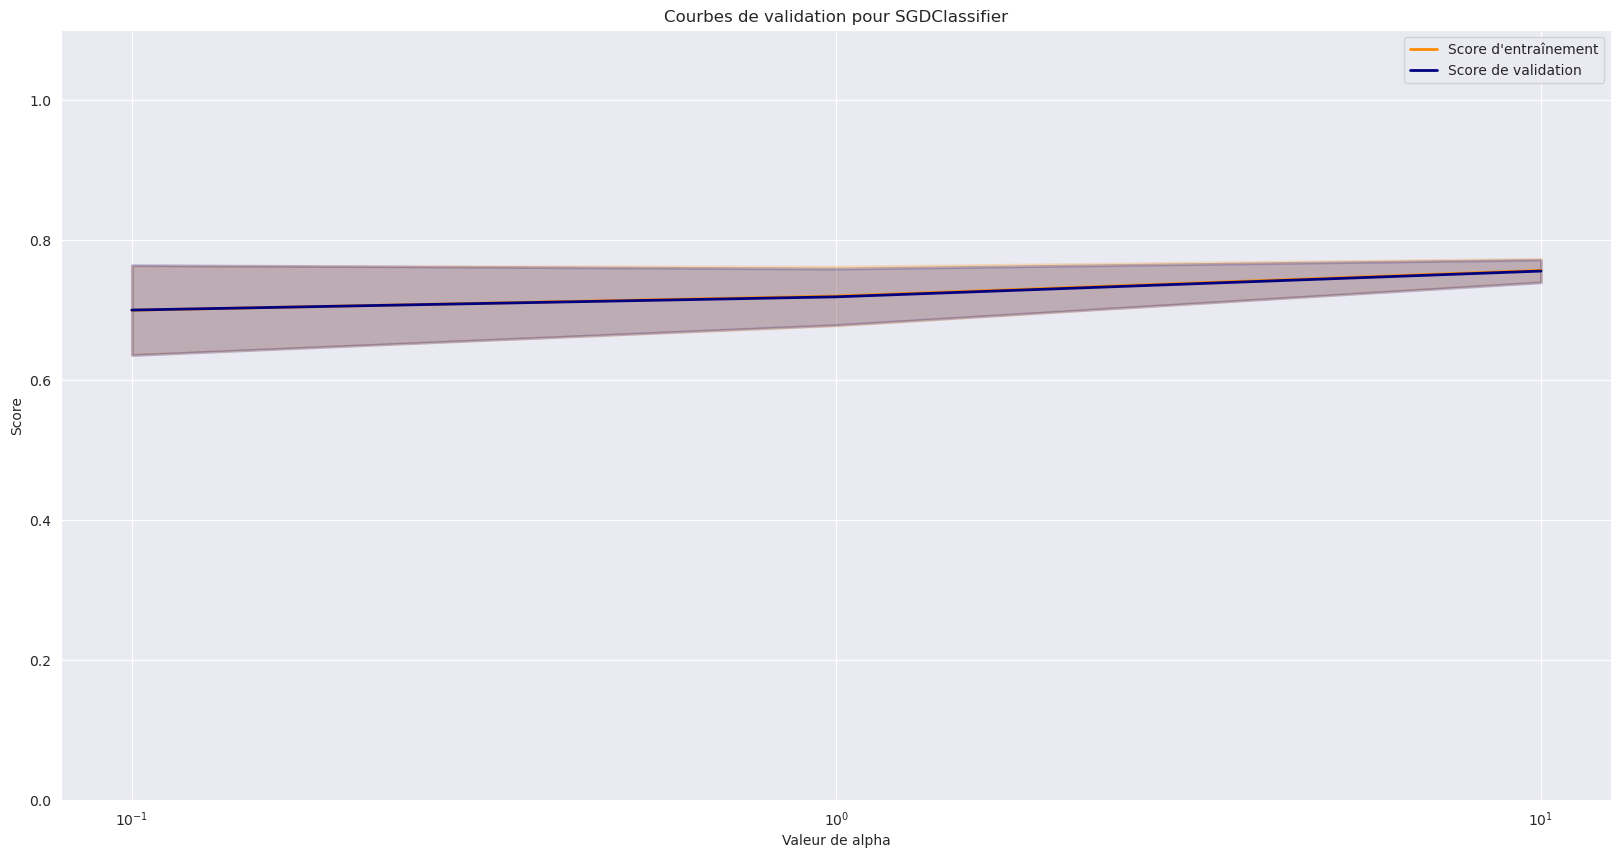

In [55]:
# Définir la gamme de valeurs pour alpha
alphas = [0.1, 1, 10]

# Créer un modèle SGDClassifier
model_clf_2 = SGDClassifier(loss='hinge', penalty='l2', max_iter=1000, tol=1e-3, random_state=0)

# Calculer les scores de validation croisée pour chaque valeur d'alpha
train_scores, valid_scores = validation_curve(model_clf_2, X_train, y_train, param_name="alpha", param_range=alphas, cv=5)

# Calculer la moyenne et l'écart type des scores de validation croisée
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)
# Traçage des courbes de validation
plt.figure(figsize=(20, 10))
plt.title("Courbes de validation pour SGDClassifier")
plt.xlabel("Valeur de alpha")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
plt.semilogx(alphas, train_scores_mean, label="Score d'entraînement", color="darkorange", lw=2)
plt.fill_between(alphas, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="darkorange", lw=2)
plt.semilogx(alphas, valid_scores_mean, label="Score de validation", color="navy", lw=2)
plt.fill_between(alphas, valid_scores_mean - valid_scores_std, valid_scores_mean + valid_scores_std, alpha=0.2, color="navy", lw=2)
plt.legend(loc="best")
plt.show()

## Learning Curve

In [56]:
from sklearn.model_selection import learning_curve

In [57]:
train_sizes = np.linspace(0.2, 1.0, num=5)

In [58]:
N, train_score, valid_score = learning_curve(model_clf_2, X_train, y_train, train_sizes=train_sizes, cv=5)

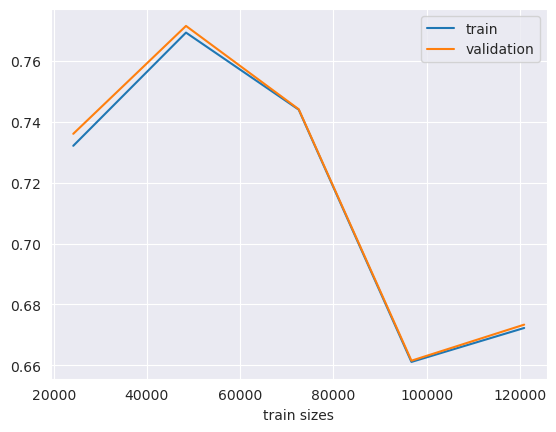

In [59]:
plt.plot(N, train_score.mean(axis=1), label='train')
plt.plot(N, valid_score.mean(axis=1), label='validation')
plt.xlabel('train sizes')
plt.legend()

## Prepa before GridSearchCV

In [60]:
categorical_features = ['RainToday', 'Month', 'Year']
numerical_features = ['MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed', 'Humidity', 'WindSpeed', 'Pressure', 'Temp']
# Création d'un pipeline pour traiter les caractéristiques
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

## GridSearchCV - For SGD Classifier

In [61]:
# Création du pipeline avec SGDClassifier
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SGDClassifier())
])

# Définition de la grille de recherche des hyperparamètres
param_grid = [
    {
        'classifier__loss': ['hinge', 'log_loss'],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
        'classifier__max_iter': [1000]
    }
]

# Recherche sur la grille des hyperparamètres avec validation croisée
grid_search = GridSearchCV(pipeline, param_grid, cv=5, verbose=2)
grid_search.fit(X_train, y_train)

# Affichage des meilleurs paramètres
print("Meilleurs paramètres trouvés :")
print(grid_search.best_params_)

Fitting 5 folds for each of 28 candidates, totalling 140 fits
[CV] END classifier__alpha=0.0001, classifier__loss=hinge, classifier__max_iter=1000, classifier__penalty=l1; total time=   0.6s
[CV] END classifier__alpha=0.0001, classifier__loss=hinge, classifier__max_iter=1000, classifier__penalty=l1; total time=   0.7s
[CV] END classifier__alpha=0.0001, classifier__loss=hinge, classifier__max_iter=1000, classifier__penalty=l1; total time=   0.7s
[CV] END classifier__alpha=0.0001, classifier__loss=hinge, classifier__max_iter=1000, classifier__penalty=l1; total time=   0.6s
[CV] END classifier__alpha=0.0001, classifier__loss=hinge, classifier__max_iter=1000, classifier__penalty=l1; total time=   0.6s
[CV] END classifier__alpha=0.0001, classifier__loss=hinge, classifier__max_iter=1000, classifier__penalty=l2; total time=   0.5s
[CV] END classifier__alpha=0.0001, classifier__loss=hinge, classifier__max_iter=1000, classifier__penalty=l2; total time=   0.4s
[CV] END classifier__alpha=0.0001, 

In [62]:
grid_search.best_score_

0.7781747080124555

In [63]:
y_pred = grid_search.predict(X_test)

In [64]:
from sklearn.metrics import classification_report

In [65]:
print("Rapport de classification :")
print(classification_report(y_test, y_pred))

Rapport de classification :
              precision    recall  f1-score   support

       False       0.77      0.79      0.78     18958
        True       0.78      0.76      0.77     18834

    accuracy                           0.78     37792
   macro avg       0.78      0.78      0.78     37792
weighted avg       0.78      0.78      0.78     37792


In [66]:
# Utilisation des meilleurs paramètres trouvés par la recherche sur la grille
best_params = grid_search.best_params_
# Supprimer le préfixe 'classifier__' des clés de best_params
best_params = {key.replace('classifier__', ''): value for key, value in best_params.items()}
# Création d'un nouveau modèle avec les meilleurs paramètres
best_model = SGDClassifier(**best_params)
best_params

{'alpha': 0.001, 'loss': 'hinge', 'max_iter': 1000, 'penalty': 'l2'}

In [67]:
# Création d'un nouveau modèle avec les meilleurs paramètres
best_model = SGDClassifier(**best_params)
best_model

SGDClassifier(alpha=0.001)

In [68]:
# Entraînement du modèle sur l'ensemble des données d'entraînement
best_model.fit(X_train, y_train)

SGDClassifier(alpha=0.001)

In [69]:
# Prédiction sur l'ensemble des données de test
y_pred = best_model.predict(X_test)

# Évaluation de la performance du modèle
accuracy = accuracy_score(y_test, y_pred)
print("Précision du modèle sur l'ensemble des données de test :", accuracy)

Précision du modèle sur l'ensemble des données de test : 0.7492061812023709


In [70]:
from joblib import dump

# Sauvegarde du modèle dans un fichier
dump(best_model, 'ML_SGDClassifier_balanced.joblib')

['ML_SGDClassifier_balanced.joblib']